In [28]:
import numpy as np
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import csv
from datetime import date, datetime
import datetime
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import RobustScaler
from scipy.spatial.distance import euclidean
from sklearn.feature_selection import f_regression
from statsmodels.tsa.stattools import adfuller
from sklearn.manifold import TSNE
from DBCV import DBCV
import hdbscan
import csv
import multiprocessing
import itertools
import operator
plt.style.use('fivethirtyeight')
from osgeo import gdal 
from subprocess import Popen
import numpy.ma as ma
from numpy import linalg as LA
from dtaidistance import dtw

In [371]:
from rasterio.transform import Affine

In [12]:
class Data():
    
    def __init__(self, filename1, filename2, pc=0.3):
        self.load(filename1, filename2, pc)
        
    def set_latitudes(self, latitudes):
        self.latitudes = latitudes
        
    def set_longitudes(self, longitudes):
        self.longitudes = longitudes
        
    def set_topo(self, topo):
        self.topo = topo
        
    def set_ns_mean_velocities(self, velocities):
        self.ns_mean_velocities = velocities
        
    def set_ew_mean_velocities(self, velocities):
        self.ew_mean_velocities = velocities
    
    def set_dates(self, dates):
        self.dates = dates
    
    def set_ns_displacements(self, ns_displacements):
        self.ns_displacements = ns_displacements
        
    def set_ew_displacements(self, ew_displacements):
        self.ew_displacements = ew_displacements
        
    def load(self, ns_file_path, ew_file_path, pc):
        ns_displacements, ew_displacements, booleans = [], [], []
        ns_infos, ns = self.load_component(ns_file_path)
        ew_infos, ew = self.load_component(ew_file_path)
        m = len(ns[0])
        
        mask = [(ns[n].isnull().sum().sum() / len(ns[0])) < pc for n in range(len(ns))]
        
        for n, components in enumerate(zip(ns, ew)):
            if ns[n].isnull().sum().sum() / m < pc:
                ns_displacements.append(components[0].interpolate(limit_direction='both', inplace=False)['displacement'].values)
                ew_displacements.append(components[1].interpolate(limit_direction='both', inplace=False)['displacement'].values)
                booleans.append(False)
            else:
                booleans.append(True)
            
        self.set_latitudes(ns_infos['Lat'].values[mask])
        self.set_longitudes(ns_infos['Lon'].values[mask])
        self.set_topo(ns_infos['Topo'].values[mask])
        self.set_ns_mean_velocities(ns_infos['Vel'].values[mask])
        self.set_ew_mean_velocities(ew_infos['Vel'].values[mask])
        self.set_ns_displacements(np.array(ns_displacements))
        self.set_ew_displacements(np.array(ew_displacements))
        self.set_dates(ns[0].index)
        
    #np.count_nonzero(np.isnan(data))
    def load_image_correlation(self, ns_fi, ew_filename):
        df_ns, df_ns_ts = self.load_component(ns_filename)
        df_ew, df_ew_ts = self.load_component(ew_filename)
        df_ew.rename(columns={'Vel': 'Vel_ew'}, inplace=True)
        df_ns.rename(columns={'Vel': 'Vel_ns'}, inplace=True)
        geo = pd.concat([df_ew[['id', 'Lat','Lon','Topo','Vel_ew']], df_ns[['Vel_ns']]], axis=1)
        return geo, df_ns_ts, df_ew_ts
        
    def load_component(self, filename):
        
        # numéro de la ligne ou commence les données
        num_start = 44
        # numéro de la ligne ou se trouve la liste des dates
        num_list_dates = 40
        # attributs présent dans les données
        columns = ['id', 'Lat','Lon', 'Topo', 'Vel', 'Coer',' CosN', 'CosE', 'CosU']
        # dictionnaire stockant les données
        data = {column: [] for column in columns}
        # liste des dates 
        indexes = []
        # series temporelles
        series = []
        # liste de dataframes
        df_series = []
        
        with open(filename) as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=",")
            line_count = 1 
            for row in csv_reader:
                if line_count == num_list_dates:
                    indexes = [row[0].split(' ')[1]] + row[1:]
                if line_count >= num_start:
                    # extraction des premiers attributs
                    for i in range(len(columns)):
                        data[columns[i]].append(row[i])
                    # extraction de l'attribut TS(série temporelle)
                    series.append([float(v) for v in row[len(columns):]])
                line_count  += 1
            if len(indexes) != len(series[0]):
                print('Erreur : Les indexes et les valeurs ne correspondent pas')
            # convertir les index en date
            indexes = [d.strip()[0:8] for d in indexes]
            # créer une liste de dataframes, chacun contenant une série temporelle
            for serie in series:
                tmp_serie = pd.DataFrame({'displacement': pd.Series(serie, index=pd.DatetimeIndex(indexes))})
                tmp_serie.sort_index(inplace=True)
                df_series.append(tmp_serie)
            # creer un dataframe pour les autres attributs
            df = pd.DataFrame(data)
            for column in df.columns:
                df[column] = pd.to_numeric(df[column], errors='coerce')
            df.set_index('id')
        return df, df_series

In [29]:
class Displacement():
    def __init__(self):
        pass
    
    def compute_velocity(self, displacement):
        return 0
    
    def test(self):
        return 0
    
    def is_mean_velocity_significant(self, displacements, days):
        # extraire X et y
        X = StandardScaler().fit_transform(displacements)
        # calculer la p-value de la regression lineaire
        _, pval = f_regression(X, days)
        return  pval[0]
    
    def compute_inst_vel(self, displacements, dates):
        diff_displacements, durations = self.prepare(displacements, dates)
        return np.divide(diff_displacements, durations)
    
    # TODO
    def is_stationary(self, displacement, alpha, freq='D'):
        resampled = displacement.resample(freq)
        interpolated = upsampled.interpolate(method='linear')
        return self.compute_adfuller(interpolated) < alpha
    
     # TODO
    def smooth(self, displacement, factor):
        std = math.sqrt(serie.var())
        for i in range(len(serie)):
            if abs(serie.iloc[i].displacement) > ampl*std:
                serie.iloc[i, serie.columns.get_loc('displacement')]= np.nan
        return serie.interpolate(limit_direction='both', inplace=False)
    
    def prepare(self, displacement, dates):
        durations = np.diff(dates) / np.timedelta64(1,'D')
        return self.transform_displacement(displacement), self.transform_date(dates)
    
    def transform_date(self, dates):
        temp = np.diff(np.array(dates))
        shifted = np.array([np.timedelta64(1, 'D') for n in range(temp.shape[0])])
        shifted[0:-1] = temp[1:]
        return (shifted + temp)[:-1] / np.timedelta64(1,'D')
    
    def transform_displacement(self, displacement):
        temp = np.diff(np.array(displacement))
        shifted = np.zeros(temp.shape[0])
        shifted[0:-1] = temp[1:]
        return np.add(temp, shifted)[:-1]
    
    def transform_dates_for_lnreg(self, dates):
        lnr_dates = np.cumsum( np.diff(data.dates) /  np.timedelta64(1,'D') )
        return np.insert(lnr_dates, 0, 0, axis=0)

In [15]:
class DataFromImageCorrelation():
    
    def __init__(self, data, raster_folder_name, dem_filename, pc=0.4, alpha=0.05, ref='wgs84'):
        self.data  = data
        self.compute_slope_map(raster_folder_name, dem_filename)
        self.compute_vlm_std()
        self.n_cores = multiprocessing.cpu_count()
        self.pc = pc
        self.ref = ref
        self.alpha = alpha
        self.velocities = []
        self.mask = np.array([])
    
    def compute_vel(self, ns_component, ew_component):
        return math.sqrt(ns_component * ns_component + ew_component * ew_component)
    
    def is_ns_mean_velocity_significant(self, n):
        displacement = self.data.ns_displacements[n].reshape(-1, 1)
        dates = Displacement().transform_dates_for_lnreg(self.data.dates)
        return Displacement().is_mean_velocity_significant(displacement, dates) < self.alpha
    
    def is_ew_mean_velocity_significant(self, n):
        displacement = self.data.ew_displacements[n].reshape(-1, 1)
        dates = Displacement().transform_dates_for_lnreg(self.data.dates)
        return Displacement().is_mean_velocity_significant(displacement, dates) < self.alpha
    
    def is_mean_velocity_significant(self, n):
        return self.is_ns_mean_velocity_significant(n) and self.is_ew_mean_velocity_significant(n)
    
    def is_moving(self, n, factor):
        ns_vel = data.ns_mean_velocities[n]
        ew_vel = data.ew_mean_velocities[n]
        return self.compute_vel(ns_vel, ew_vel) > factor * self.sigma
    
    def filter_by(self, factor, min_slope=5):
        vfunc = np.vectorize(self.is_to_select)
        self.mask = vfunc(np.arange(self.data.latitudes.shape[0]), factor, min_slope)

    def is_to_select(self, n, factor, min_slope):
        return (self.is_moving(n, factor) and
               self.is_ns_mean_velocity_significant(n) and
                self.is_ew_mean_velocity_significant(n))
    
    def filter_by_linear_reg(self):
        pass
                
    def compute_vlm_std(self):
        vfunc = np.vectorize(self.compute_vel)
        ns_velocities = self.data.ns_mean_velocities
        ew_velocities = self.data.ew_mean_velocities
        self.sigma = np.std(vfunc(ns_velocities, ew_velocities))
        
    def compute_inst_vels(self, series):
        with multiprocessing.Pool(self.n_cores) as p:
            results = p.map(Displacement().compute_inst_vel, series)
            return results
        
    def compute_velocities(self):
        if self.mask.shape[0] > 0:
            ns_displacements = self.data.ns_displacements[~np.array(self.mask)]
            ew_displacements = self.data.ew_displacements[~np.array(self.mask)]
            ns_vels = self.compute_inst_vels(ns_displacements)
            ew_vels = self.compute_inst_vels(ew_displacements)
            vfunc = np.vectorize(self.compute_vel)
            self.velocities = np.array([vfunc(ns, ew) for ns, ew in zip(ns_displacements, ew_displacements)])
                    
    def set_slope_map_path(self, slope_map_path):
        self.slope_map_path = slope_map_path
        
    def load_raster(self, raster_folder_name, raster_filename):
        return gdal.Open(raster_folder_name + '/' +  raster_filename)
        
    def compute_slope_map(self, raster_folder_name, dem_name):
        dem = None
        slope_map = None
        slope_map_name = dem_name.split('.')[0] + '_' + 'slope_map.tif'
        slope_map_path = raster_folder_name + '/' + slope_map_name
        if not os.path.isfile(slope_map_path):
            dem = gdal.Open(raster_folder_name + '/'+ dem_name)
            slope_map = gdal.DEMProcessing(slope_map_path, dem, 'slope', computeEdges = True)
        self.set_slope_map_path(slope_map_path)

# Application

## Chargement des données

In [30]:
DATA_PATH  = './donnees' 
ns_path = 'rasters/Lavalette/MM_TIO_NS_31TGK_20151227_to_20200906.csv'
ew_path = 'rasters/Lavalette/MM_TIO_EW_31TGK_20151227_to_20200906.csv'

In [31]:
data = Data(ns_path, ew_path)

FileNotFoundError: [Errno 2] No such file or directory: 'rasters/Lavalette/MM_TIO_NS_31TGK_20151227_to_20200906.csv'

## Calcul des profils de vitesse

In [32]:
raster_folder_path = 'rasters'
dem_filename =  '31TGK_copernicus_dem.tif'

In [ ]:
img_correlation = DataFromImageCorrelation(data, raster_folder_path, dem_filename)

In [18]:
 def plot_disp_ns_ew(ns_ts, ew_ts):

        fig, ax = plt.subplots(2, 1, figsize=(15,10))

        ax[0].plot(ns_ts, color='blue', label='displacement (m)', marker='o', linewidth=2)
        ax[0].set_title('NS cumulative displacement')
        ax[0].set_xlabel('time')
        ax[0].set_ylabel('displacement')
        ax[0].legend()

        ax[1].plot(ew_ts, color='orange', label='displacement (m)', marker='o', linewidth=2)
        ax[1].set_title('EW cumulative displacement')
        ax[1].set_xlabel('time')
        ax[1].set_ylabel('displacement')
        ax[1].legend()
        plt.savefig('displacement.png')
        fig.tight_layout()
        plt.show()
        

## Analyse en composantes princpales(PCA) et décomposition en composantes indépendantes (ICA)

In [33]:
from sklearn.decomposition import PCA, FastICA

# Sélection des sources

# Remarques

* les deux méthodes ne renvoient pas la même amplitude 
* amplitude plus faible avec ICA
* les sources avec PCA sont obtenues dans la base orthogonal formée par les composantes principales


In [34]:
def generate_kml_file(latitudes, longitudes, color, kml=None, filename='visualization', generate=True):
    
    url = 'http://maps.google.com/mapfiles/ms/micons/'
    kml = simplekml.Kml()
    for n, coords in enumerate(zip(latitudes, longitudes)):
        pnt = kml.newpoint(description=str(n), coords=[(coords[0], coords[1])])
        pnt.iconstyle.icon.href = url + color + '-dot.png'
    if generate:
        kml.save(filename + '.kml')
        return  None
    else:
        return kml
        

# Décomposition en composantes indépendantes

In [35]:
ica_path = 'donnees/ica/'

In [36]:
import os

In [262]:
# UU : EW
# VV : NS
def load_displacements(ica_path):
    uu, vv = [], []
    for filename in os.listdir(ica_path):
        if 'FILTER_Displmax' in filename:
            raster = gdal.Open(ica_path + filename)
            values = raster.GetRasterBand(1).ReadAsArray()
            if 'MM_NS' in filename:
                vv.append(values)
            if 'MM_EW' in filename:
                uu.append(values)
    return np.array(uu), np.array(vv)

In [582]:
def get_component_filenames(ica_path, component):
    filenames = []
    for filename in os.listdir(ica_path):
        if 'FILTER_Displmax' in filename and  component in filename:
            filenames.append(filename)
    return filenames

In [220]:
UU, VV = load_displacements(ica_path)

In [221]:
UU.shape

(1612, 299, 293)

In [183]:
UU = []
VV = []
F2 = os.listdir(ica_path)
for f in F2:
    if f.startswith('MM_EW') and f.endswith('.tif'):
        ds = gdal.Open(ica_path + f)
        img = ds.ReadAsArray()
        UU.append(img)
    if f.startswith('MM_NS') and f.endswith('.tif'):
        ds = gdal.Open(ica_path + f)
        img = ds.ReadAsArray()
        VV.append(img)

In [223]:
from datetime import datetime

def to_date(string):
    year = string[0:4]
    month = string[4:6]
    day = string[6:8]
    new_str = ' '.join([year, month, day])
    return datetime.strptime(new_str, "%Y %m %d")

def to_filename(year, month, day):
    new_month = None
    new_day   = None
    if month < 10:
        new_month = '0' + str(month)
    else:
        new_month = str(month)
    if day < 10:
        new_day = '0' + str(day)
    else:
        new_day = str(day)
        
    return str(year) + new_month + new_day 

def checked_connection_(date1, date2, filenames):
    year1, month1, day1 = date1.year, date1.month, date1.day
    year2, month2, day2 = date2.year, date2.month, date2.day
    for filename in filenames:
        if to_filename(year1, month1, day1) in filename and to_filename(year2, month2, day2) in filename:
            return 1
        else:
            return 0

In [226]:
def check_connection(date1, date2, filenames):
    for filename in filenames:
         if 1 in filenames:
            return True
    return False

def extract_dates(filenames):
    dates = [s for filename in filenames for s in filename.split('_') if s.isdigit()]
    dates = list(OrderedDict.fromkeys(sorted(dates)))
    return sorted(dates)

In [227]:
 from collections import OrderedDict
# filenames = get_component_filenames(ica_path, 'MM_NS')
# dates = [s for filename in filenames for s in filename.split('_') if s.isdigit()]
# dates = [to_date(date) for date in dates]
# dates = sorted(dates)
# dates = list(OrderedDict.fromkeys(sorted(dates)))
# dates

In [583]:
filenames = get_component_filenames(ica_path, 'MM_NS')
dates  = extract_dates(filenames)

In [620]:
for filename in filenames:
    if dates[0] in filename and dates[1] in filename:
        print('Couple existe')
        break
print('Couple n\'existe pas')

Couple n'existe pas


In [508]:
couples_dict = {}
for n in range(len(dates)):
    for m in range(n + 1, len(dates)):
        status = False
        for filename in filenames:
            if dates[n] in filename and dates[m] in filename:
                status = True
                couples_dict[str(n)] = m
        if status:
            break

In [663]:
# construction de la matrice A
A = []
for n in range(len(dates)):
    for m in range(n + 1, len(dates)):
        for filename in filenames:
            if dates[n] in filename and dates[m] in filename:
                b = np.zeros(len(dates))
                b[n:m] = 1
                A.append(b)

In [664]:
AA = np.linalg.pinv(np.transpose(A).dot(A)).dot(np.transpose(A))

In [668]:
A = []
for n in range(len(dates)):
    for m in range(n + 1, len(dates)):
        for filename in filenames:
            if dates[n] in filename and dates[m] in filename:
                b = np.zeros(len(dates))
                b[n:m] = 1
                A.append(b)
AA = np.linalg.pinv(np.transpose(A).dot(A)).dot(np.transpose(A))

In [217]:
A = []
for n in range(len(dates)):
    for m in range(n + 1, len(dates)):
        for filename in filenames:
            if dates[n] in filename and dates[m] in filename:
                A.append(b)
#AA = np.linalg.inv(np.transpose(A).dot(A)).dot(np.transpose(A))

In [652]:
vv_4ica=[]
uu_4ica=[]
for i in range(0, np.size(VV,1)):
    for j in range(0, np.size(UU,2)):
            vv_4ica.append(VV[:,i,j])
            uu_4ica.append(UU[:,i,j]) 

In [80]:
print(np.array(A).shape, np.array(uu_4ica).shape)

(1298466, 87) (87607, 1612)


In [743]:
Nica=40
icav = FastICA(n_components=Nica, whiten='boolean')
icau = FastICA(n_components=Nica, whiten='boolean')

S_v = icav.fit_transform(vv_4ica)  # Reconstruct signals
S_u = icau.fit_transform(uu_4ica)  # Reconstruct signals
S_v_t = np.transpose(S_v)
S_u_t = np.transpose(S_u)
A_v = icav.mixing_
A_u = icau.mixing_

In [367]:
def from_utm_to_lat_lon(filename):
        # Read raster
        with rasterio.open(filename) as r:
            T0 = r.transform  # upper-left pixel corner affine transform
            p1 = Proj(r.crs)
            A = r.read()  # pixel values

        # All rows and columns
        cols, rows = np.meshgrid(np.arange(A.shape[2]), np.arange(A.shape[1]))

        # Get affine transform for pixel centres
        T1 = T0 * Affine.translation(0.5, 0.5)
        # Function to convert pixel row/column index (from 0) to easting/northing at centre
        rc2en = lambda r, c: (c, r) * T1

        # All eastings and northings (there is probably a faster way to do this)
        eastings, northings = np.vectorize(rc2en, otypes=[float, float])(rows, cols)

        # Project all longitudes, latitudes
        p2 = Proj(proj='latlong',datum='WGS84')
        lats, lons = transform(p1, p2, eastings, northings)

        return lats, lons

In [375]:
import rasterio
from pyproj import Proj, transform
from affine import Affine
test = rasterio.open(ica_path + 'MM_EW_displ_31TGK_20170311_vs_20200424_FILTER_Displmax.tif')
lats, lons = from_utm_to_lat_lon(ica_path + 'MM_EW_displ_31TGK_20170311_vs_20200424_FILTER_Displmax.tif')

C:\Users\PLATEF~1\AppData\Local\Temp/ipykernel_12220/1201044674.py:14: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  rc2en = lambda r, c: (c, r) * T1
C:\Users\PLATEF~1\AppData\Local\Temp/ipykernel_12220/1201044674.py:21: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lats, lons = transform(p1, p2, eastings, northings)


In [416]:
def generate_kml_file(indexes, latitudes, longitudes, color, filename='visualization_ica'):
    url = 'http://maps.google.com/mapfiles/ms/micons/'
    kml = simplekml.Kml()
    for n in range(len(latitudes)):
        pnt = kml.newpoint(description=str(indexes[n]), coords=[(latitudes[n], longitudes[n])])
        pnt.iconstyle.icon.href = url + color + '-dot.png'
    kml.save(filename + '.kml')

In [418]:
import simplekml
generate_kml_file(np.arange(28000, 35000, 1), lats.flatten()[28000:35000], lons.flatten()[28000:35000], 'yellow')

In [409]:
signals = [29753, 32690]
noise = [6488,]

In [975]:
# 80 : 1
# 75 : 1
# 70 : 1
# 65 : 1
# 60 : 0.01
# 55 : 0.1
# 50 : 0.1
# 45 : 0.1
# 40 : 0.1
# 35 : 0.1
# 30 : 0.1
# 25 : 0.01
# 20 : 0.001
# 15 : 0.001
# 10 : 0.001
# 5 : 0.001
icav = FastICA(n_components=60, whiten='boolean', tol=0.01)
S_v = icav.fit_transform(vv_4ica)  # Reconstruct signals

c:\users\plateforme_gt\appdata\local\programs\python\python39\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


In [976]:
tolerances = [0.001, 0.001, 0.001, 0.001, 0.01, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 1, 1, 1, 1,1]

In [978]:
len(nsources)

16

In [982]:
NS, EW = [], []
tolerances = [0.001, 0.001, 0.001, 0.001, 0.01, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 1, 1, 1, 1, 1]
nsources = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]

for n in range(len(nsources)):
    icav = FastICA(n_components=nsources[n], whiten='boolean', tol=tolerances[n])
    icau = FastICA(n_components=nsources[n], whiten='boolean', tol=tolerances[n])

    S_v = icav.fit_transform(vv_4ica)  # Reconstruct signals
    S_u = icau.fit_transform(uu_4ica)  # Reconstruct signals
    S_v_t = np.transpose(S_v)
    S_u_t = np.transpose(S_u)
    A_v = icav.mixing_
    A_u = icau.mixing_

    du = []
    dv = []
    for i in range(0, nsources[n]):
        du.append(AA.dot(A_u[:, i]))
        dv.append(AA.dot(A_v[:, i]))
        
    Iu_f = None
    Iv_f = None
    Ew = []
    Ns = []
    Iv_f = np.dot(np.transpose(dv), S_v.T).T
    Iu_f = np.dot(np.transpose(du), S_u.T).T
    
    for i in range(Iu_f.shape[0]):
        Ew.append(np.cumsum(Iu_f[i, :]))
        Ns.append(np.cumsum(Iv_f[i, :]))
        
    NS.append(Ns)
    EW.append(Ew)
    
    print('Decompostion %d completed' % (n))

Decompostion 0 completed
Decompostion 1 completed
Decompostion 2 completed
Decompostion 3 completed
Decompostion 4 completed
Decompostion 5 completed
Decompostion 6 completed


c:\users\plateforme_gt\appdata\local\programs\python\python39\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


Decompostion 7 completed


c:\users\plateforme_gt\appdata\local\programs\python\python39\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


Decompostion 8 completed


c:\users\plateforme_gt\appdata\local\programs\python\python39\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


Decompostion 9 completed


c:\users\plateforme_gt\appdata\local\programs\python\python39\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


Decompostion 10 completed
Decompostion 11 completed
Decompostion 12 completed
Decompostion 13 completed
Decompostion 14 completed
Decompostion 15 completed


In [1244]:
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(nsources))]

IndexError: list index out of range

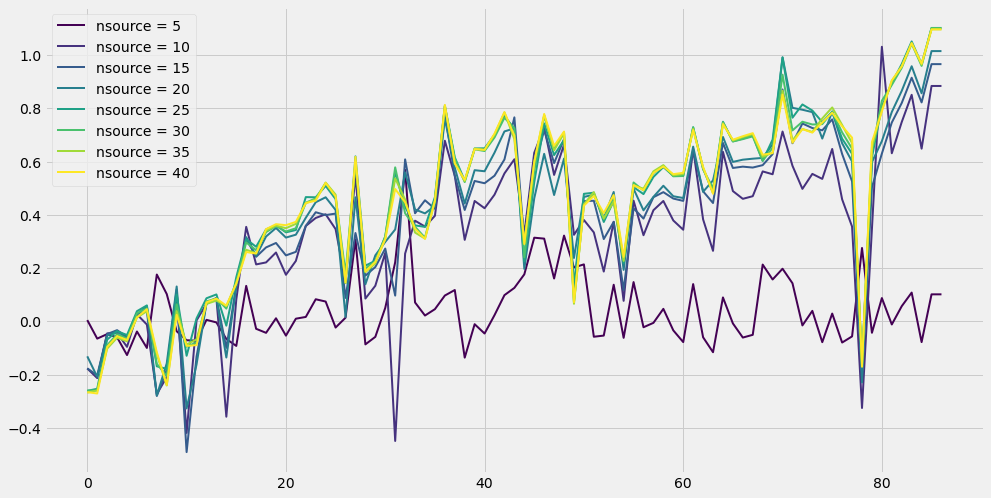

In [1245]:
sig = 29760
#colors = ['green', 'blue', 'red', 'orange', 'purple', 'gray', 'olive', 'brown']
plt.figure(figsize=(15, 8))
for m in range(len(nsources)):
    plt.plot(NS[m][sig], color=colors[m], label='nsource = %d' % (nsources[m]), linewidth=2)
    plt.legend()

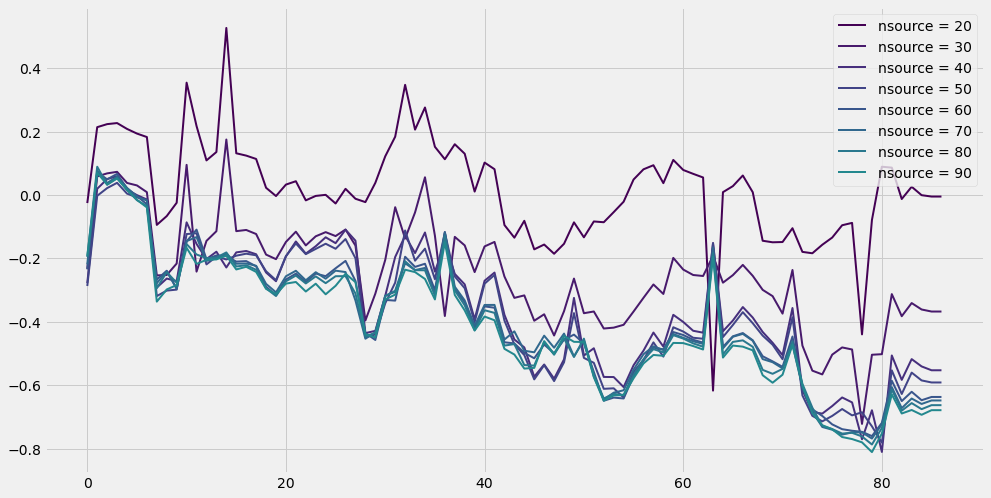

In [1242]:
sig = 29760
#colors = ['green', 'blue', 'red', 'orange', 'purple', 'gray', 'olive', 'brown']
plt.figure(figsize=(15, 8))
for m in range(len(nsources)):
    plt.plot(EW[m][sig], color=colors[m], label='nsource = %d' % (nsources[m]), linewidth=2)
    plt.legend()

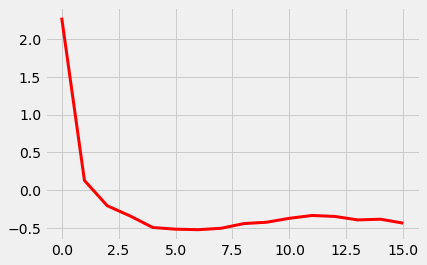

In [1166]:
kurtosis_vr_sig = []
for m in range(len(nsources)):
    kurtosis_vr_sig.append(kurtosis(NS[m][sig]))
plt.plot(kurtosis_vr_sig, color='r', linewidth=3)
plt.show()

In [924]:
from numpy import linalg as LA

In [1240]:
def compute_slope_variations(v, y):
    slopes = []
    for n in range(len(v) - 1):
        slopes.append( (v[n + 1] - v[n]) / (y[n+1] - y[n]) )
    return slopes

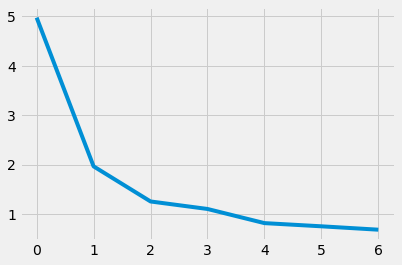

In [1241]:
distances = []
for n in range(len(nsources) - 1):
    distances.append(LA.norm(NS[-1][sig] - NS[n][sig]))
plt.plot(distances)
plt.show()

In [1167]:
for n in range(len(distances) - 1):
    percentage = 100 * abs(distances[n] - distances[n + 1]) / distances[n]
    print(nsources[n], percentage)

5 60.466183625847705
10 36.09259377737929
15 12.08947531808626
20 25.883951315649746
25 7.87593214995414
30 9.085312599445563
35 0.07458652033969522
40 11.326903005755854
45 8.675047856990798
50 14.220426683244652
55 33.17989280071586
60 1.185697293602847
65 14.703620522089123
70 3.984005958989672


In [1073]:
tol = 0.1
n = 0
while (n < len(nsources) - 1) and (LA.norm(EW[-1][noise] - EW[n][noise]) > tol):
    n += 1
    print(LA.norm(EW[-1][noise] - EW[n][noise]))
print('nombre de sources %d' % nsources[n])

1.4116134777734346
1.8693569516322182
1.9745013347861973
0.9947306440859565
1.1584884741198331
0.9788837657920271
1.1332639057840312
0.7819619480732716
0.7088435157711145
0.4908990854768489
0.42127695792243747
0.4414073760174826
0.31784101064705
0.21939481007700554
0.0
nombre de sources 80


In [ ]:
def seek_sources_number(tol):

In [1031]:
slopes = compute_slope_variations(distances, nsources[0:15])

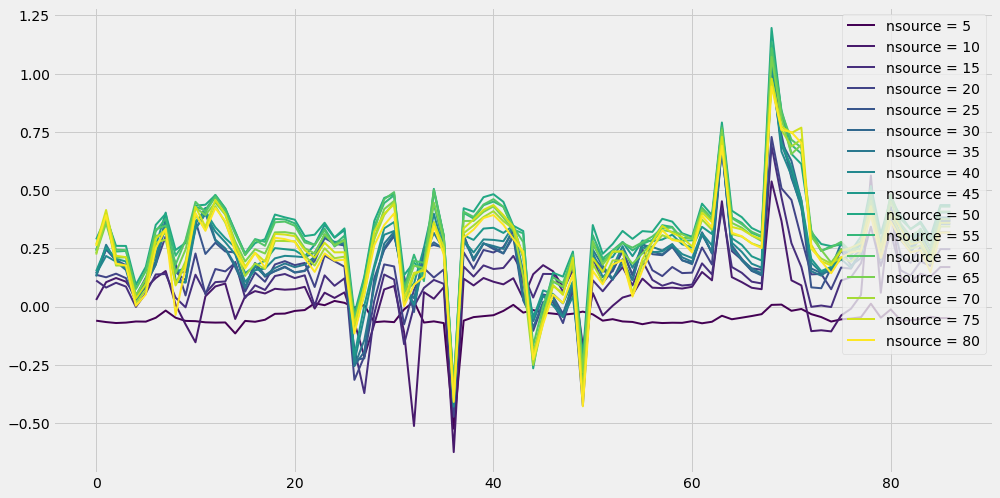

In [1005]:
noise = 28190
#colors = ['green', 'blue', 'red', 'orange', 'purple', 'gray', 'olive', 'brown']
plt.figure(figsize=(15, 8))
for m in range(len(colors)):
    plt.plot(NS[m][noise], color=colors[m], label='nsource = %d' % (nsources[m]), linewidth=2)
    plt.legend()

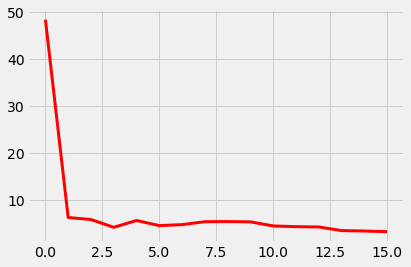

In [1011]:
kurtosis_vr_noise = []
for m in range(len(nsources)):
    kurtosis_vr_noise.append(kurtosis(NS[m][noise]))
plt.plot(np.array(kurtosis_vr_noise), color='r', linewidth=3)
plt.show()

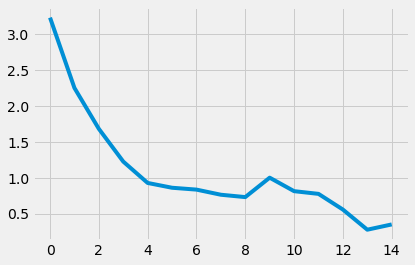

In [1015]:
distances = []
for n in range(len(nsources) - 1):
    distances.append(LA.norm(NS[-1][noise] - NS[n][noise]))
plt.plot(distances)
plt.show()

In [1329]:
n_components = 30
icav = FastICA(n_components=n_components, whiten='boolean', tol=0.01)
icau = FastICA(n_components=n_components, whiten='boolean', tol=0.01)

S_v = icav.fit_transform(vv_4ica)  # Reconstruct signals
S_u = icau.fit_transform(uu_4ica)  # Reconstruct signals
S_v_t = np.transpose(S_v)
S_u_t = np.transpose(S_u)
A_v = icav.mixing_
A_u = icau.mixing_

du = []
dv = []
#for i in range(0, n_components):
    #du.append(AA.dot(A_u[:, i]))
    #dv.append(AA.dot(A_v[:, i]))
        
Iu_f = None
Iv_f = None
Ew = []
Ns = []
#Iv_f = np.dot(np.transpose(dv), S_v.T).T
#Iu_f = np.dot(np.transpose(du), S_u.T).T
    
#for i in range(Iu_f.shape[0]):
        #Ew.append(np.cumsum(Iu_f[i, :]))
        #Ns.append(np.cumsum(Iv_f[i, :]))
        

In [ ]:
signals = [34900, 28490, 37520, 36659, 42193, 30546, 34313, 38980, 30237, 33451, 22367, 24713, 22961, 25887, 28509]
non_signals = [47521, 40813, 47557, 47841, 49882, 43172, 48141, 41143, 45777, 44317,5842, 42256, 44879, 39398 ,46649]

In [1293]:
from scipy.stats import kurtosis
from scipy.stats import skew

C:\Users\PLATEF~1\AppData\Local\Temp/ipykernel_12220/2684172722.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10, 10))


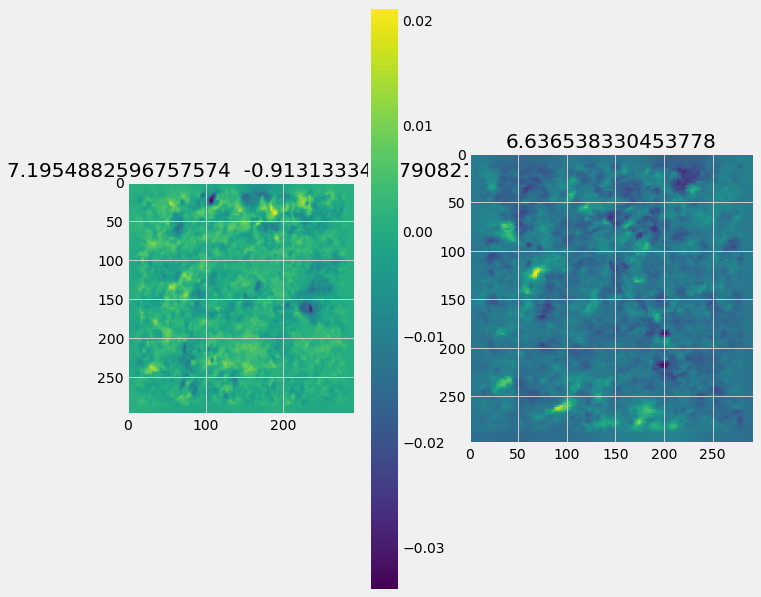

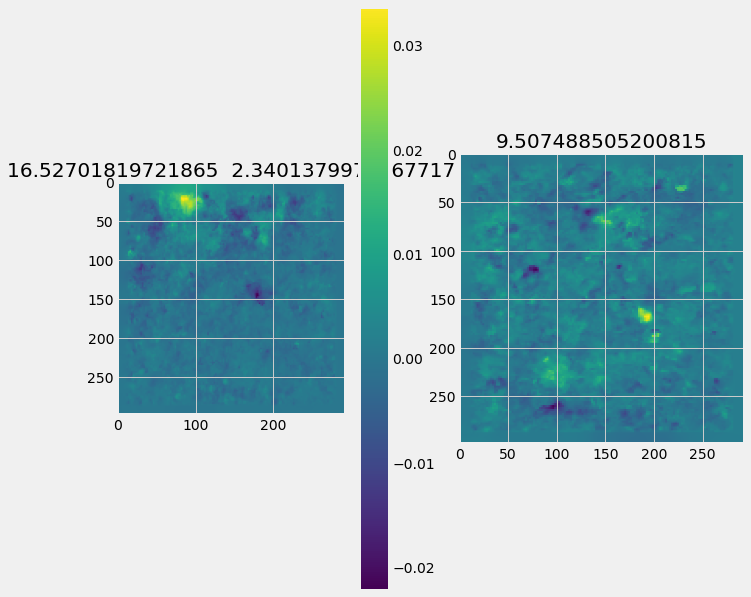

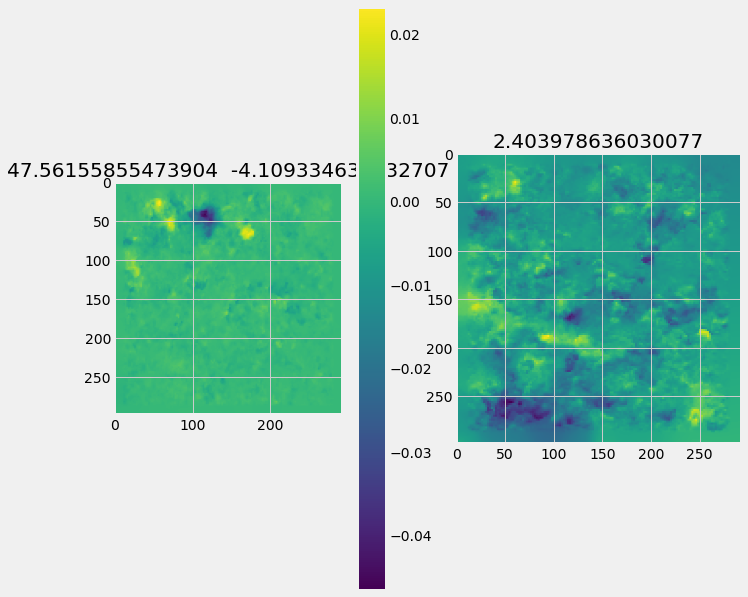

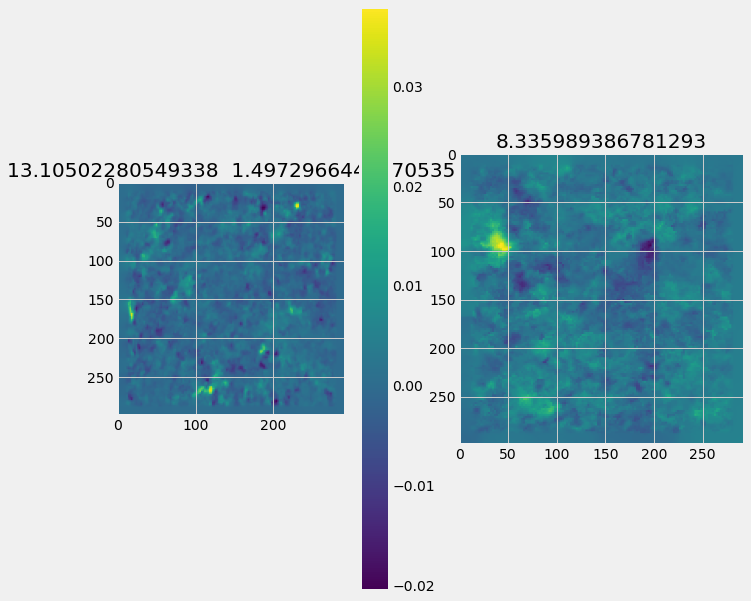

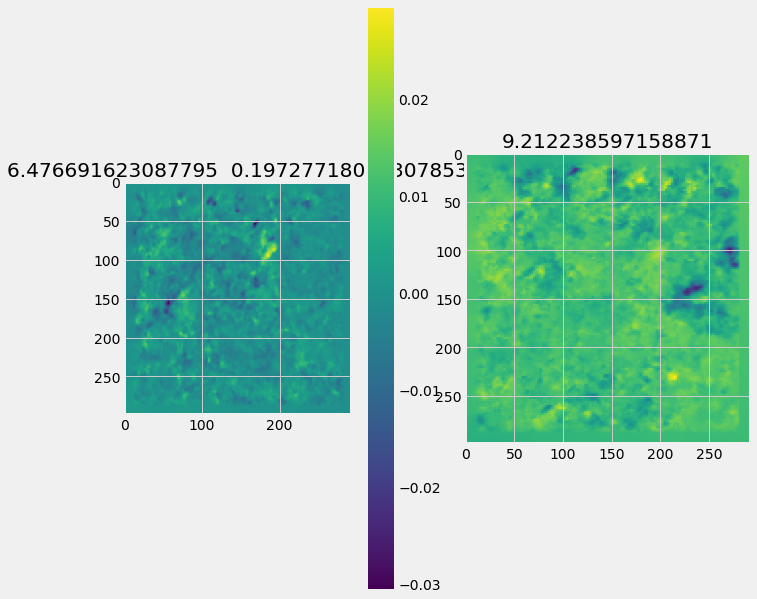

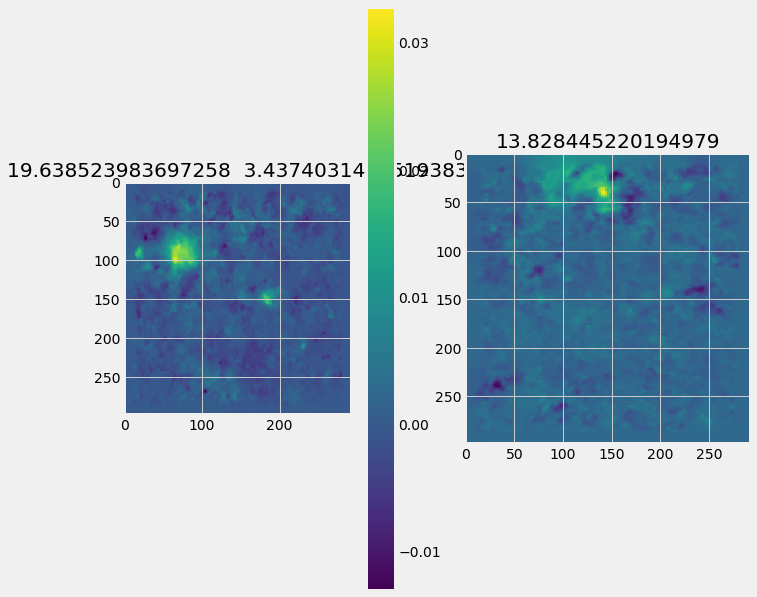

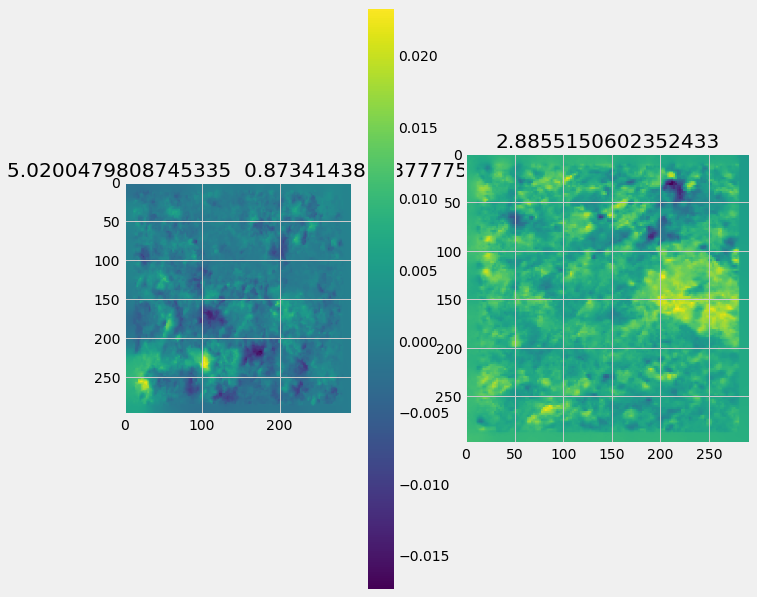

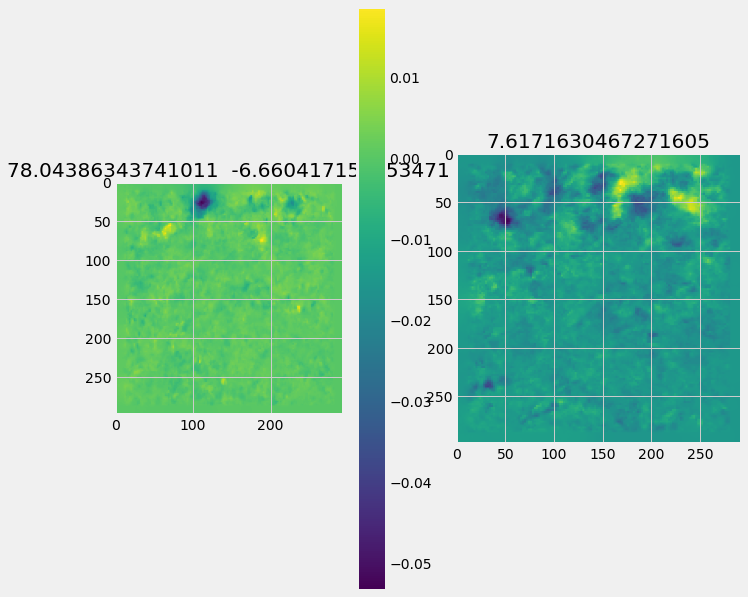

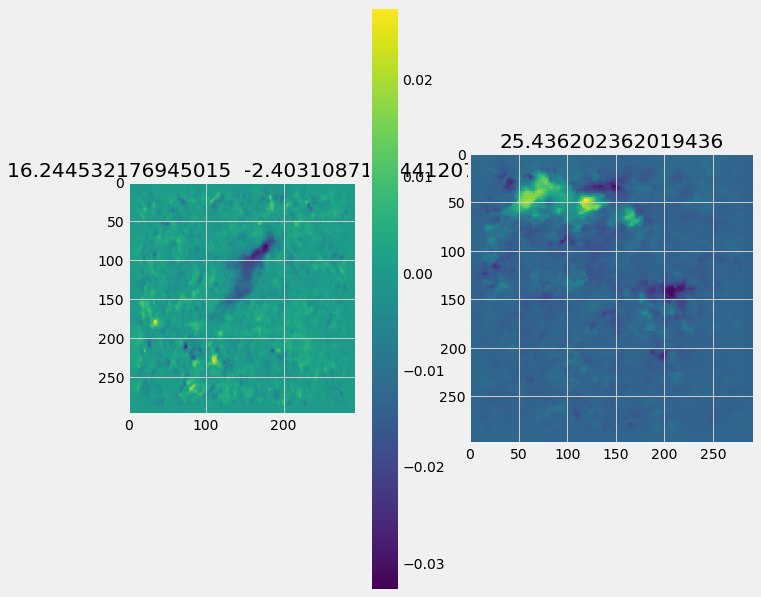

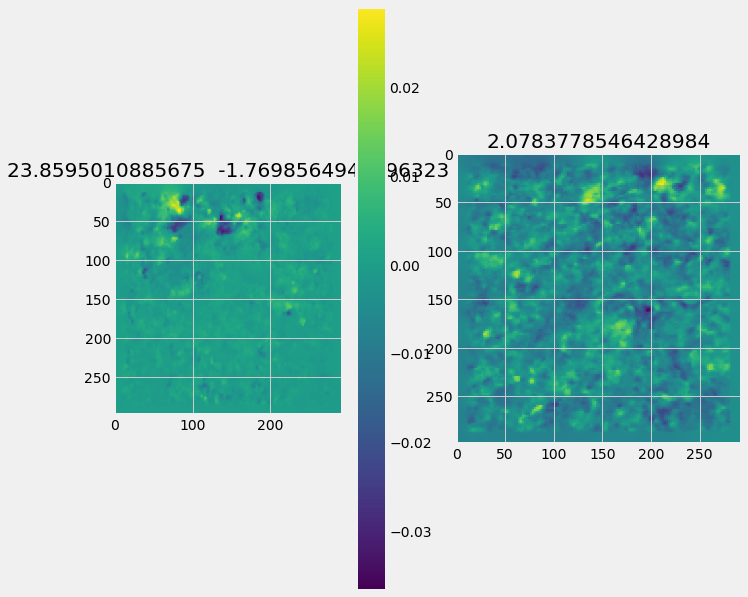

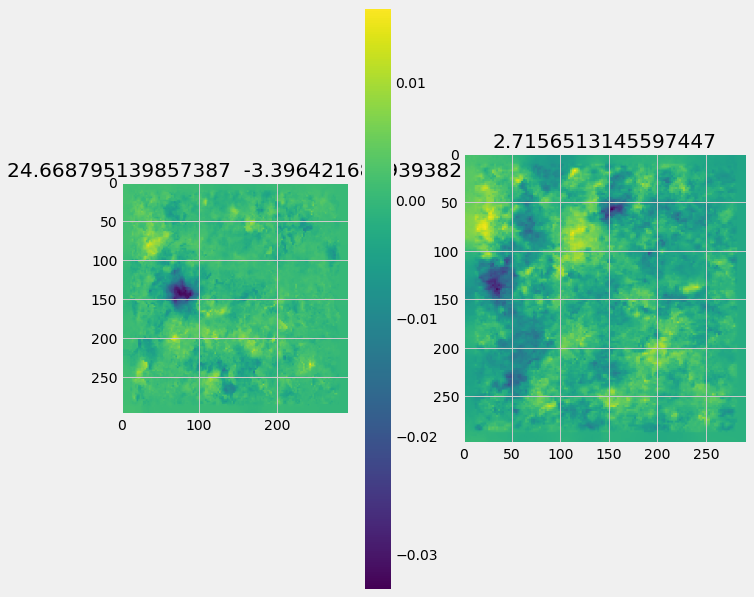

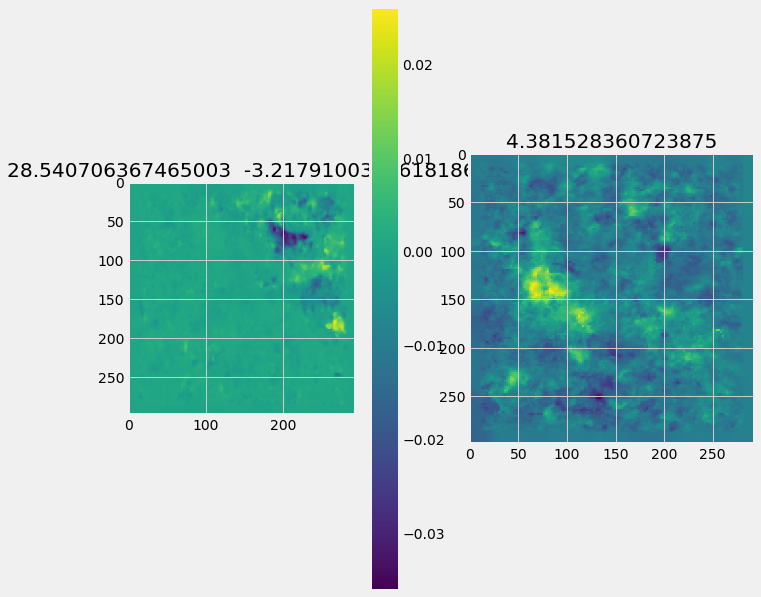

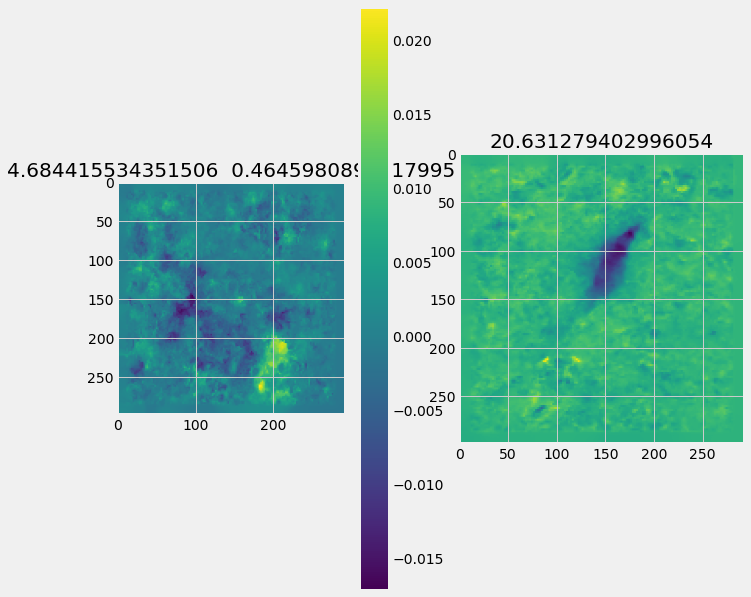

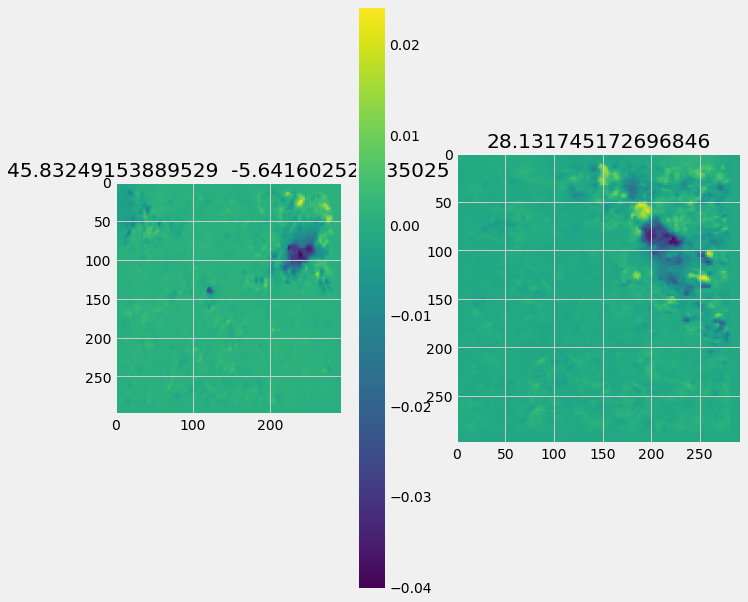

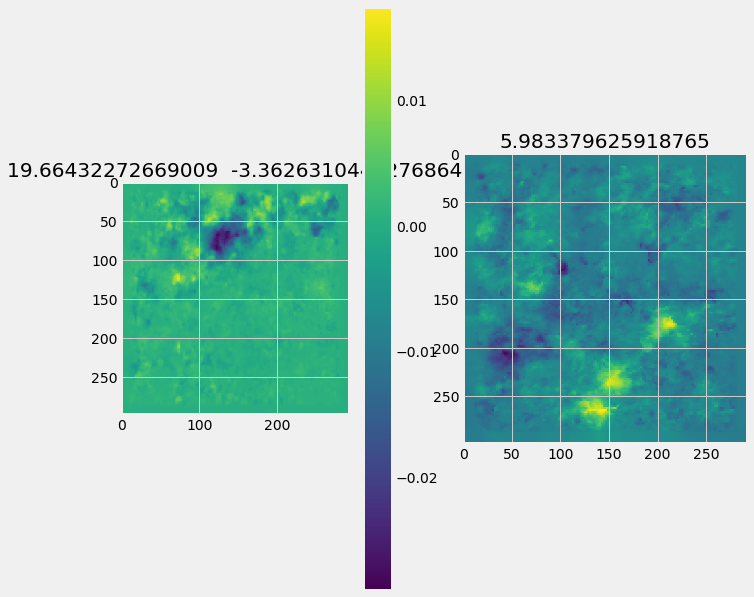

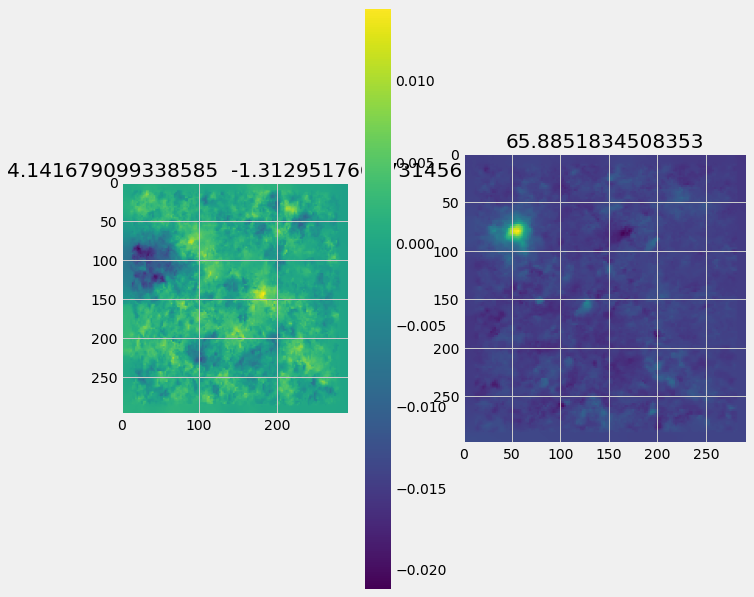

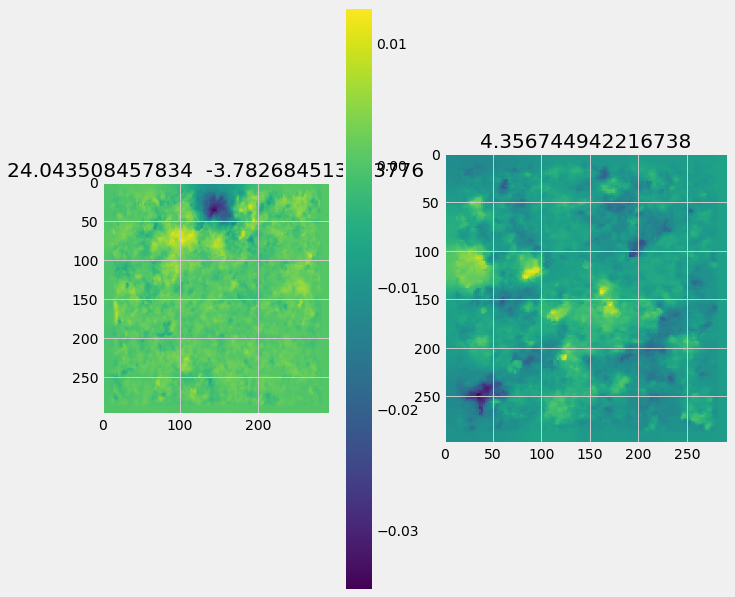

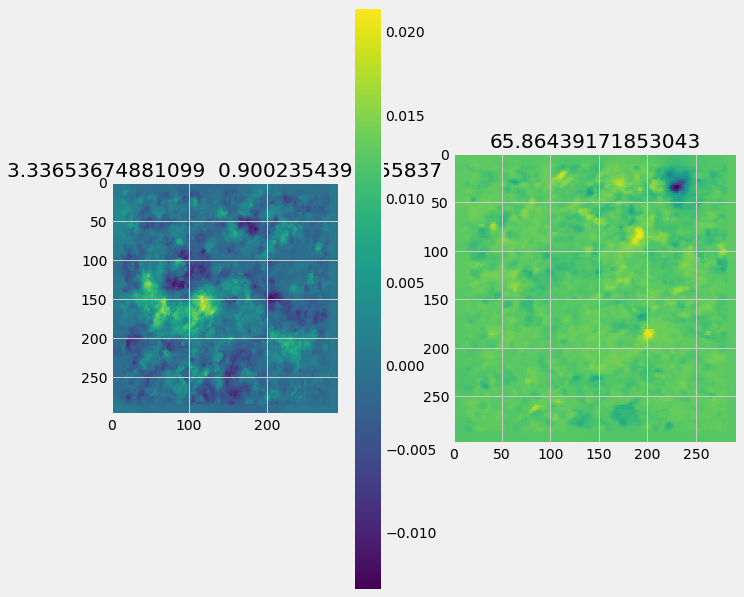

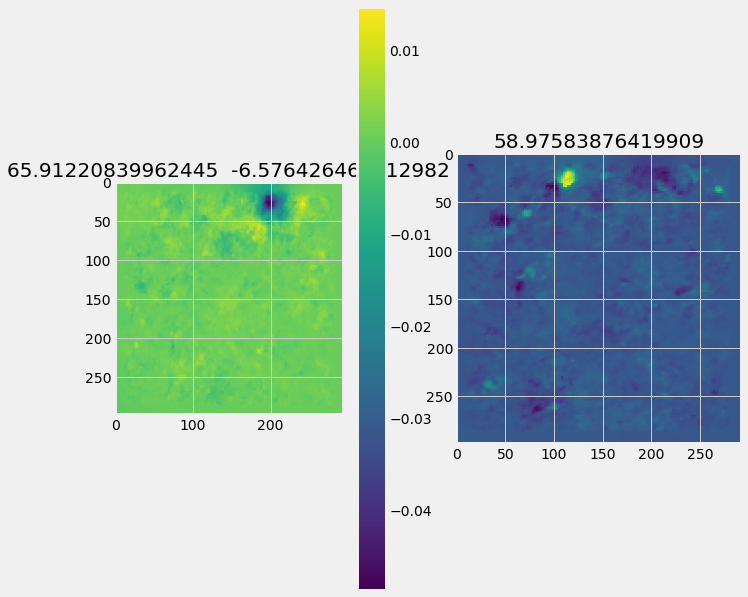

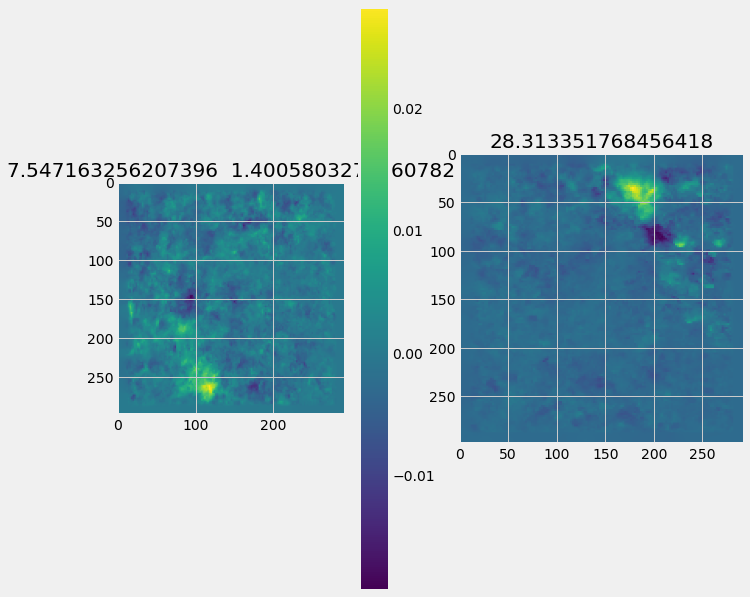

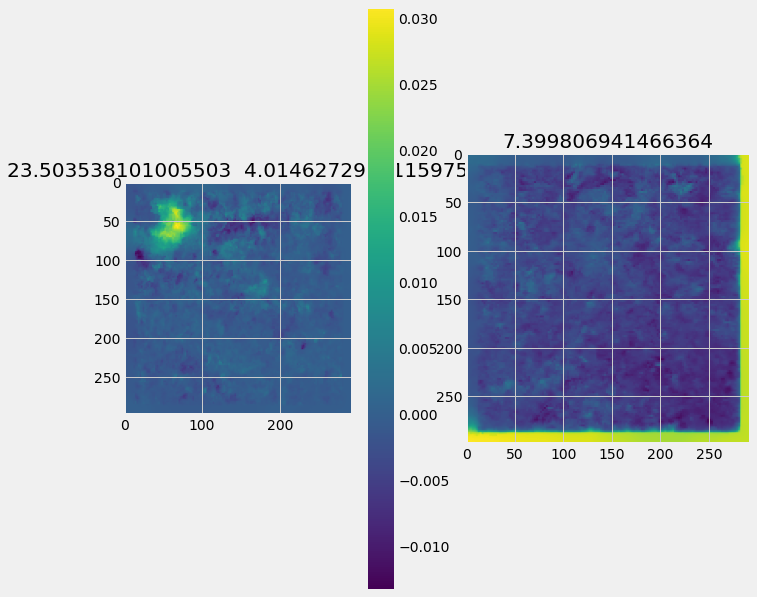

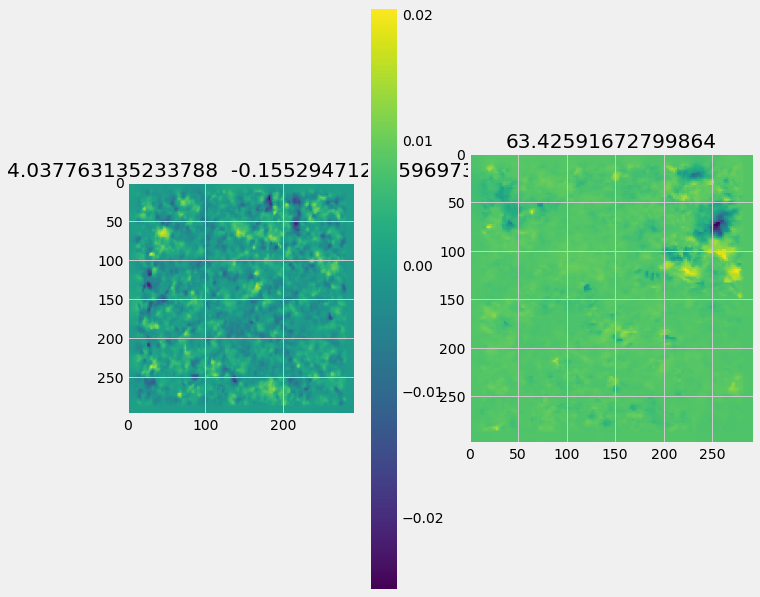

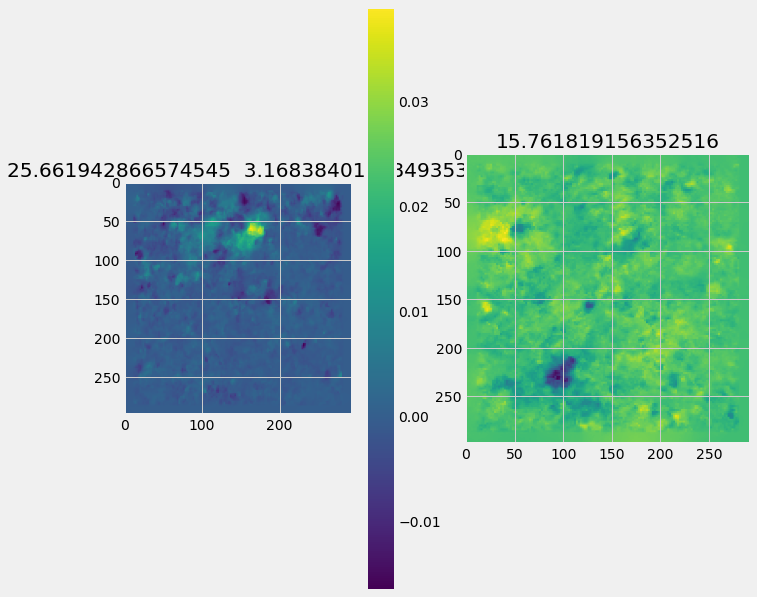

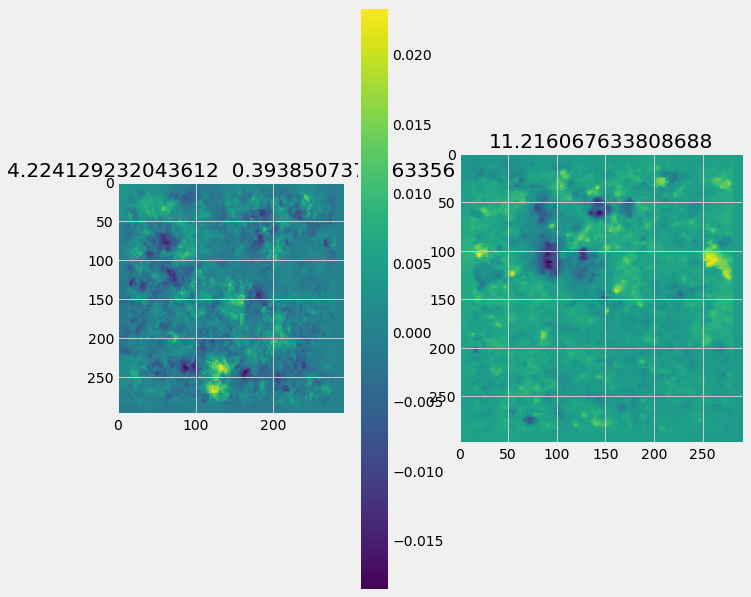

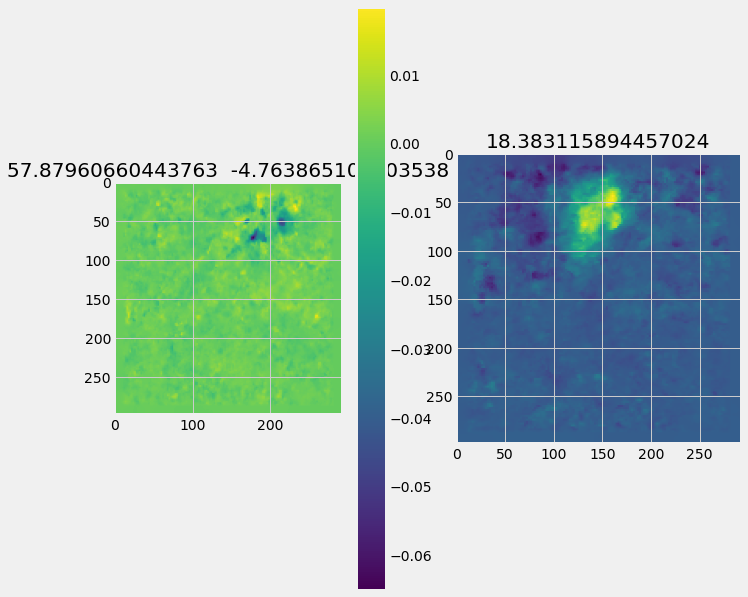

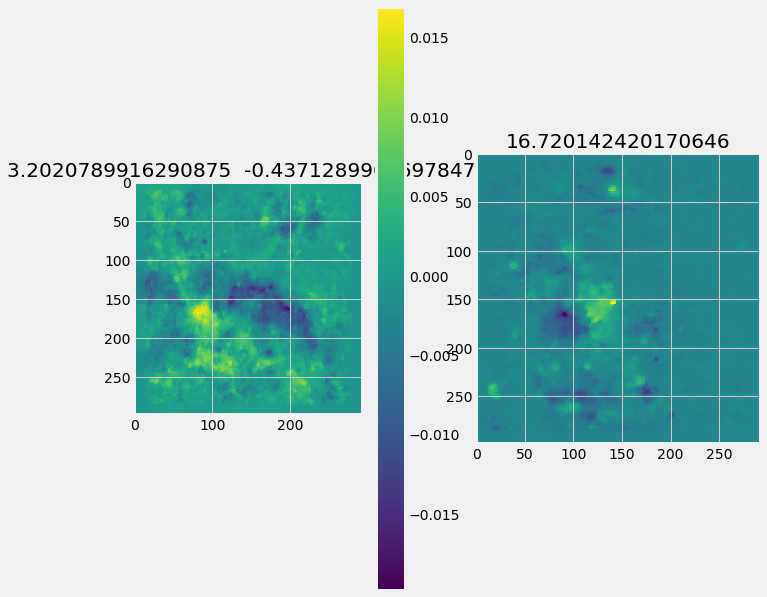

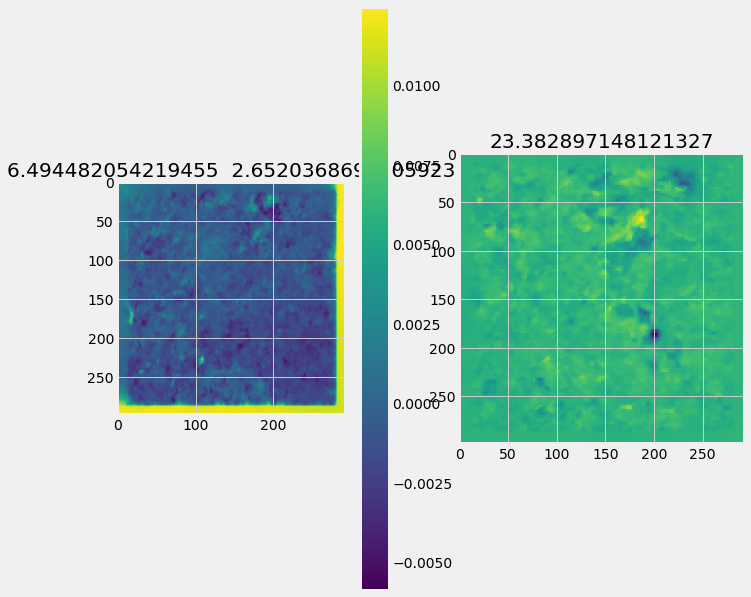

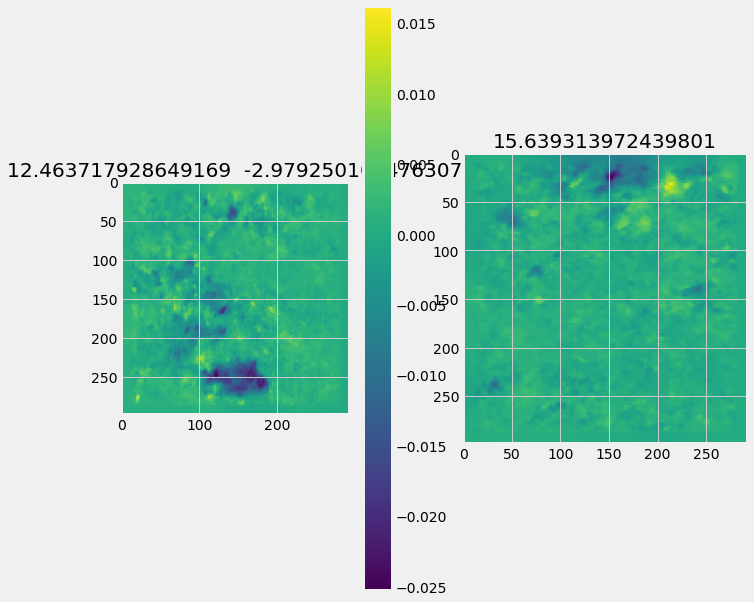

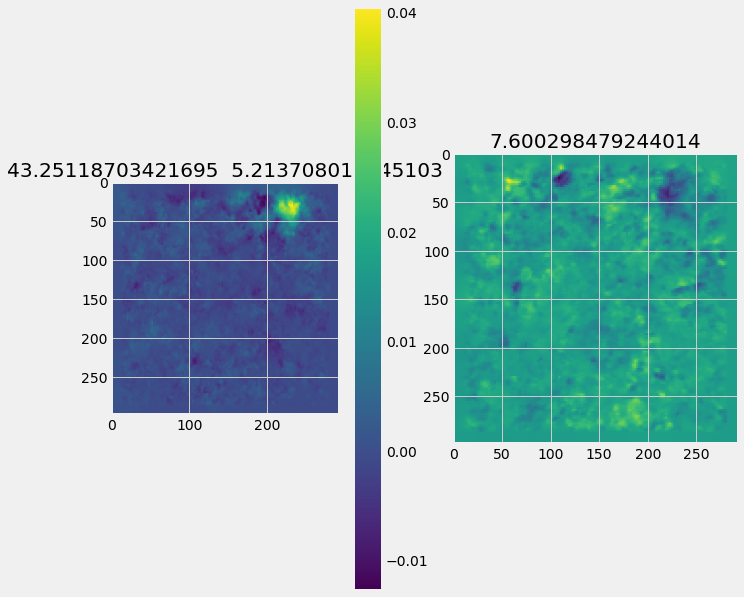

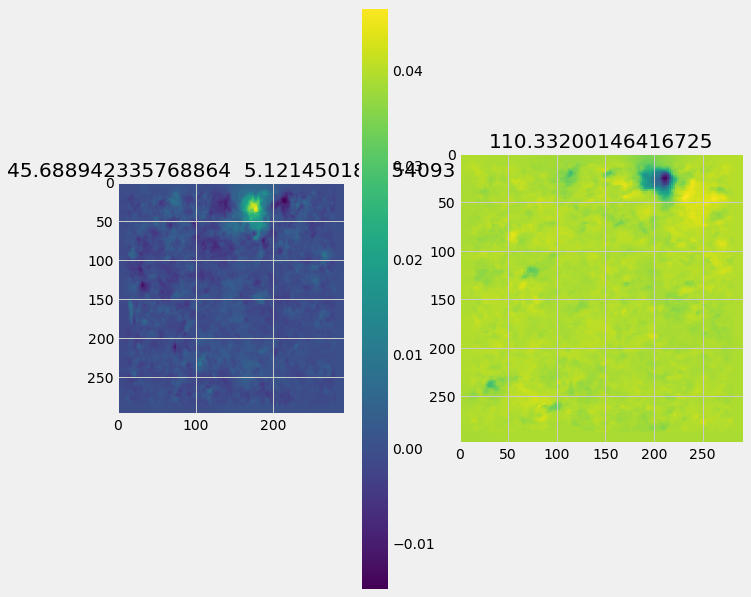

In [1330]:
for k in range(0, n_components):
    plt.figure(figsize=(10, 10))
    plt.subplot(1,2,1)
    max_val = np.max(S_u_t[k,:].flatten())
    plt.imshow(np.reshape(S_u_t[k,:], (np.size(UU,1), np.size(UU,2))))
    plt.title(str(kurtosis(S_u_t[k,:])) + "  " + str(skew(S_u_t[k,:])))
    plt.colorbar()
    plt.subplot(1,2,2)
    plt.imshow(np.reshape(S_v_t[k,:], (np.size(UU,1), np.size(UU,2))))
    plt.title(kurtosis(S_v_t[k,:]))
plt.show()

In [1144]:
X = np.random.normal(0, 1, size=(UU.shape[1], UU.shape[2]))

In [1238]:
img_45 = ndimage.rotate(np.reshape(S_u_t[19,:], (np.size(UU,1), np.size(UU,2))), 180, reshape=False)

In [1331]:
# trier les sources dans l'ordre croissant de leur kurtosis
kurtosis_u = {}
kurtosis_v = {}
for n in range(n_components):
    kurtosis_u[n] = kurtosis(S_u_t[n,:])
    kurtosis_v[n] = kurtosis(S_v_t[n,:])
kurtosis_u_sorted = {k: v for k, v in sorted(kurtosis_u.items(), key=lambda item: item[1])}
kurtosis_v_sorted = {k: v for k, v in sorted(kurtosis_v.items(), key=lambda item: item[1])}

In [1332]:
kurtosis_u_sorted

{25: 3.2020789916290875,
 17: 3.33653674881099,
 21: 4.037763135233788,
 15: 4.141679099338585,
 23: 4.224129232043612,
 12: 4.684415534351506,
 6: 5.0200479808745335,
 4: 6.476691623087795,
 26: 6.494482054219455,
 0: 7.1954882596757574,
 19: 7.547163256207396,
 27: 12.463717928649169,
 3: 13.10502280549338,
 8: 16.244532176945015,
 1: 16.52701819721865,
 5: 19.638523983697258,
 14: 19.66432272669009,
 20: 23.503538101005503,
 9: 23.8595010885675,
 16: 24.043508457834,
 10: 24.668795139857387,
 22: 25.661942866574545,
 11: 28.540706367465003,
 28: 43.25118703421695,
 29: 45.688942335768864,
 13: 45.83249153889529,
 2: 47.56155855473904,
 24: 57.87960660443763,
 18: 65.91220839962445,
 7: 78.04386343741011}

In [1301]:
keys = kurtosis_u_sorted.keys()
keys 

dict_keys([14, 9, 8, 7, 3, 28, 5, 26, 6, 0, 16, 13, 1, 24, 10, 20, 25, 23, 21, 29, 15, 2, 18, 17, 11, 12, 19, 22, 27, 4])

In [1315]:
keys = list(kurtosis_u_sorted.keys())
for n in range(len(keys) - 1):
    kurt = kurtosis(np.concatenate((S_u_t[keys[n], :], S_u_t[keys[n + 1], :])).flatten())
    print(keys[n] , kurt)

14 2.3759240318791273
9 2.9248721483271254
8 3.1812050373486045
7 3.3147706926415275
3 4.311518214284581
28 5.272390444723785
5 5.903724513636963
26 6.583260270782766
6 7.212941228991337
0 7.9276941405551185
16 9.58269197603532
13 11.74316546967323
1 13.83226902333628
24 15.763178002689731
10 17.725822301920815
20 21.19519759908619
25 23.49888269321128
23 24.06959968761501
21 24.970197288362453
29 25.711562744579602
15 27.182099358805967
2 29.485811512416042
18 35.48484646151792
17 40.504034585482984
11 41.90022431862471
12 44.55761335734613
19 47.335446748839594
22 53.50231342285282
27 61.36196315482711


In [1300]:
for k, v in kurtosis_u_sorted.items():
    print(k, v)

14 2.0556913736815776
9 2.696156690076683
8 3.1535876065775703
7 3.208822468119635
3 3.420718917163426
28 5.202317511405726
5 5.342463378041854
26 6.464985649232062
6 6.701534892333479
0 7.724347565649186
16 8.131040715461035
13 11.0343432366096
1 12.451987702736856
24 15.212550343935735
10 16.31380566144372
20 19.137838942397902
25 23.252556255774472
23 23.74520913064806
21 24.393990244581964
29 25.546404332142956
15 25.876721157016227
2 28.487477560595657
18 30.484145464236434
17 40.4855474587994
11 40.52252171216654
12 43.27792692508288
19 45.83729978960936
22 48.83359370806983
27 58.1710331376358
4 64.55289317201847


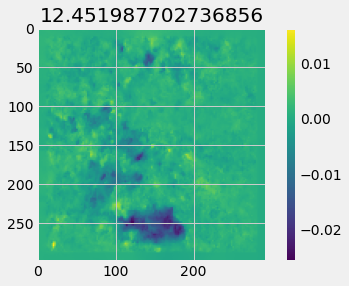

In [1318]:
k = 1
plt.imshow(S_u_t[k, :].reshape((UU.shape[1], UU.shape[2])))
plt.title(kurtosis(S_u_t[k, :]))
plt.colorbar()
plt.show()

In [1146]:
from scipy import ndimage, misc

In [734]:
from scipy.stats import norm, kurtosis

In [1173]:
# ajouter progressivement le sources et observer le comportement des séries temporelles ?
NS_, EW_ = [], []
for k, v in kurtosis_u_sorted.items():
    
    S_u_c = S_u[:, :]
    S_v_c = S_v[:, :]
    
    for n in range(S_u.shape[1]):
        if k != n:
            S_u_c[:, n] = 0
            S_v_c[:, n] = 0
            
    Iu_f = None
    Iv_f = None
    Ew_ = []
    Ns_ = []
    Iv_f = np.dot(np.transpose(dv), S_v_c.T).T
    Iu_f = np.dot(np.transpose(du), S_u_c.T).T

    for i in range(Iu_f.shape[0]):
            Ew.append(np.cumsum(Iu_f[i, :]))
            Ns.append(np.cumsum(Iv_f[i, :]))
    EW_.append(Ew)
    NS_.append(Ns)

# Distrubution de la kurtosis en fonction du nombre de sources

In [1205]:
kurtosis_u_t, kurtosis_v_t = [], []
nsources = [20, 30, 40, 50, 60, 70, 80, 90]
#nsources = [20, 30]

for n in range(len(nsources)):
    
    icav = FastICA(n_components=nsources[n], whiten='boolean', tol=1)
    icau = FastICA(n_components=nsources[n], whiten='boolean', tol=1)

    S_v = icav.fit_transform(vv_4ica)  # Reconstruct signals
    S_u = icau.fit_transform(uu_4ica)  # Reconstruct signals
    S_v_t = np.transpose(S_v)
    S_u_t = np.transpose(S_u)
    A_v = icav.mixing_
    A_u = icau.mixing_
    
    kurtosis_u = []
    kurtosis_v = []
    
    for m in range(nsources[n]):
        kurtosis_u.append(kurtosis(S_u_t[m,:]))
        kurtosis_v.append(kurtosis(S_v_t[m,:]))
    
    kurtosis_u_t.append(kurtosis_u)
    kurtosis_v_t.append(kurtosis_v)
    
    print('Execution with n = %d completed' % nsources[n])

Execution with n = 20 completed
Execution with n = 30 completed
Execution with n = 40 completed
Execution with n = 50 completed
Execution with n = 60 completed
Execution with n = 70 completed
Execution with n = 80 completed
Execution with n = 90 completed


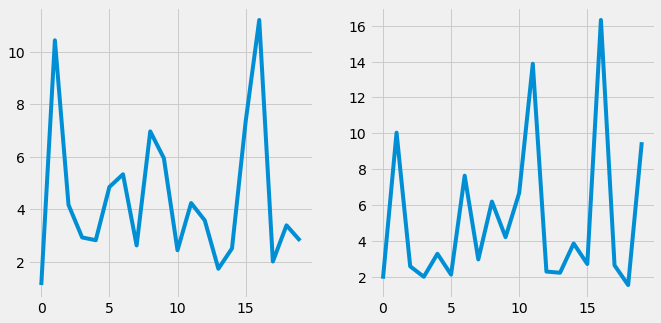

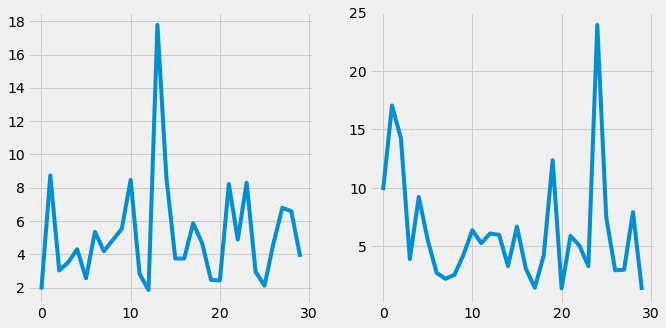

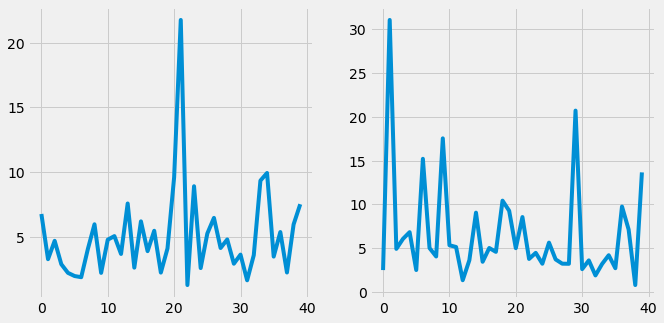

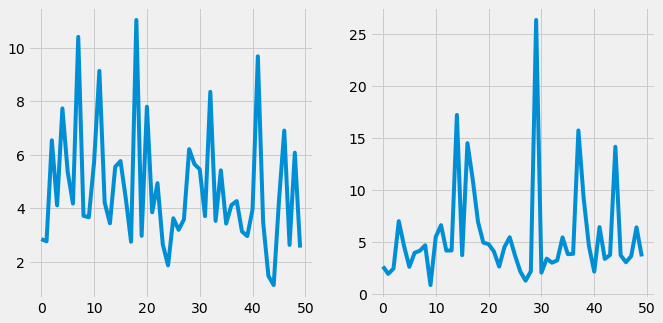

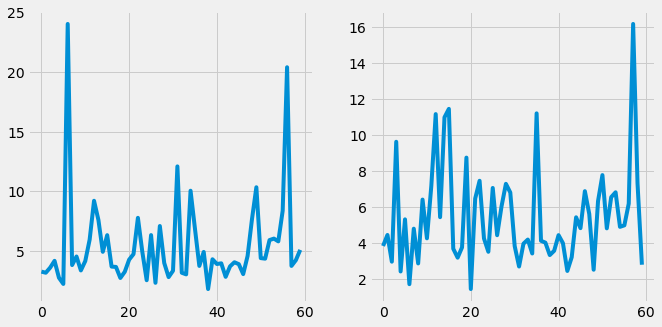

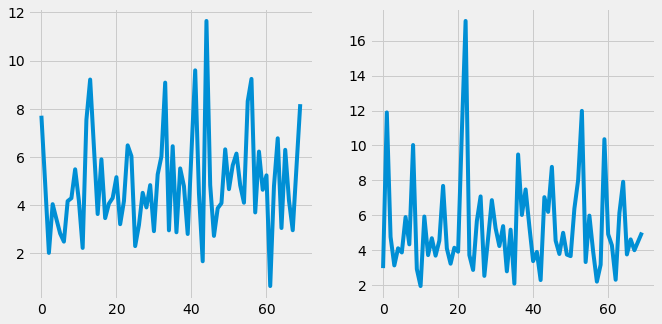

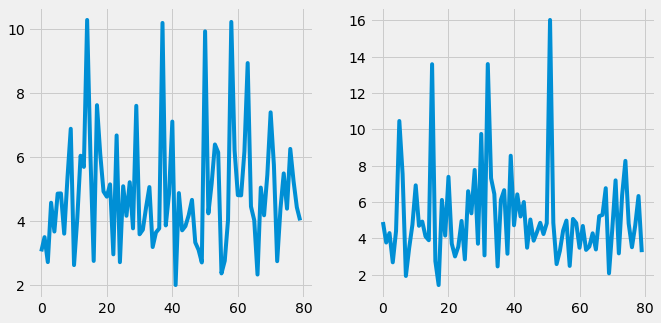

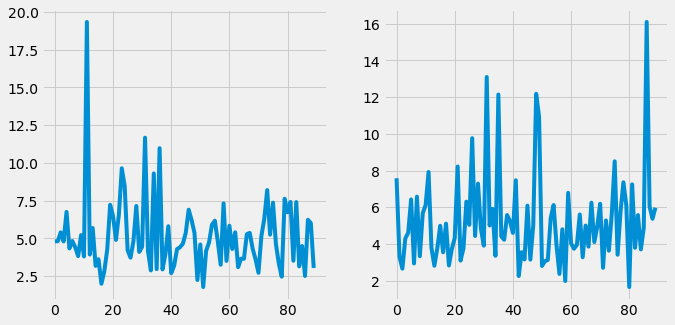

In [1215]:
for n in range(len(kurtosis_u_t)):
    plt.figure(figsize=(10, 5))
    plt.subplot(1,2,1)
    plt.plot(kurtosis_u_t[n])
    plt.subplot(1,2,2)
    plt.plot(kurtosis_v_t[n])

# Création des données de base

In [1326]:
n_components = 30
icav = FastICA(n_components=n_components, whiten='boolean', tol=0.01)
icau = FastICA(n_components=n_components, whiten='boolean', tol=0.01)

S_v = icav.fit_transform(vv_4ica)  # Reconstruct signals
S_u = icau.fit_transform(uu_4ica)  # Reconstruct signals
S_v_t = np.transpose(S_v)
S_u_t = np.transpose(S_u)
A_v = icav.mixing_
A_u = icau.mixing_

du = []
dv = []
for i in range(0, n_components):
    du.append(AA.dot(A_u[:, i]))
    dv.append(AA.dot(A_v[:, i]))
        
Iu_f = None
Iv_f = None
Ew = []
Ns = []
Iv_f = np.dot(np.transpose(dv), S_v.T).T
Iu_f = np.dot(np.transpose(du), S_u.T).T
    
for i in range(Iu_f.shape[0]):
        Ew.append(np.cumsum(Iu_f[i, :]))
        Ns.append(np.cumsum(Iv_f[i, :]))
        

In [1327]:
# trier les sources dans l'ordre croissant de leur kurtosis
kurtosis_u = {}
kurtosis_v = {}
for n in range(n_components):
    kurtosis_u[n] = kurtosis(S_u_t[n,:])
    kurtosis_v[n] = kurtosis(S_v_t[n,:])
kurtosis_u_sorted = {k: v for k, v in sorted(kurtosis_u.items(), key=lambda item: item[1])}
kurtosis_v_sorted = {k: v for k, v in sorted(kurtosis_v.items(), key=lambda item: item[1])}

In [1328]:
kurtosis_v_sorted

{5: 2.092785317778972,
 7: 3.491204765605864,
 20: 3.842220733535065,
 0: 4.016082868633647,
 23: 4.418194385802203,
 6: 5.619587221969752,
 21: 5.884569483607528,
 16: 7.178521807410444,
 4: 7.3882206265932435,
 19: 7.600430427202294,
 24: 8.955752061681004,
 15: 10.30558193594451,
 1: 10.792286475627812,
 9: 11.135083575802277,
 22: 12.32961644784585,
 17: 17.276445704899732,
 3: 17.942684794861886,
 2: 19.138078249690206,
 26: 20.392621044164684,
 8: 20.587781908654446,
 11: 20.734685158307894,
 18: 25.556190383685962,
 27: 29.12641019061163,
 29: 29.490968978778206,
 10: 39.71857258864891,
 28: 47.400930878980624,
 25: 55.365774748068475,
 13: 60.385064216257476,
 14: 63.3503469825237,
 12: 87.6088800959624}

# Génération de données synthétiques

# Labellisation des données

# Construction d'un réseau de neurones convolutif

# Entrainement et évaluation des performances